## Predicting Churn for Credit Card Customers using Data Mining Methods
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
### Team # 5 Members:
Martin Zagari<br>
Roberto Cancel<br>
Filipp Krasovsky<br>
<br>
GitHub Repository link: https://github.com/rcancel3/ADS505 <br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>


<p style="border:3px; border-style:solid; border-color:black; padding: 1em;">
    <b>Problem Statement</b><br>
A manager at the bank is disturbed by more and more customers leaving their credit card <br>
services. They have contacted the data science team to see if there’s viability to predict <br>
which customers are going to churn – the insights generated by this process would allow <br>
the company to proactively reach out through customer service channels and utilize <br>
available retention efforts.
</p>

### Approach Taken:
***insert the approaches once document is complete with rationale for methods deployed*** <br>
QDA+RF
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


In [1]:
import numpy as np
from numpy import exp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,  GridSearchCV

# For Logistic Regression modeling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from dmba import classificationSummary, gainsChart, liftChart
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.tree import DecisionTreeClassifier

# For Neural Network modeling
from sklearn.neural_network import MLPClassifier
from dmba import classificationSummary
from sklearn.metrics import classification_report

# For ensemble modeling - Voting for Classification
from sklearn.ensemble import VotingClassifier

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
Import the data set<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>

In [2]:
#import dataset
url = 'https://raw.githubusercontent.com/rcancel3/ADS505/main/BankChurners.csv'
df = pd.read_csv(url, index_col= None, header= 0)

#drop and transform traits:
df = df.drop("CLIENTNUM",axis=1)

def transform_flag(f):
    if(f=="Existing Customer"):
        return 0
    return 1

df.Attrition_Flag = df.apply(lambda row: transform_flag(row.Attrition_Flag),axis=1 )
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
#70-10-20 train/validation/test
test_size= int(round(len(df)*.20,0))
train, validation = train_test_split(df, test_size=0.30, random_state = 0)
validation,test   = train_test_split(validation,test_size=test_size,random_state=0)

train_index = train.index
validation_index=validation.index
test_index=test.index 

In [4]:
train.index

Int64Index([4813, 9887, 4191, 7527, 5081,  783, 7538, 6535, 4924, 1737,
            ...
            3468, 6744, 5874, 4373, 7891, 9225, 4859, 3264, 9845, 2732],
           dtype='int64', length=7088)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Describe Characteristics (Feature types, missing values, etc)  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [5]:
# dataframe.size
size = df.size
# dataframe.shape
shape = df.shape
# dataframe.ndim
ndim = df.ndim
# printing size and shape
print("Size = {}\nShape ={}\nShape[0] x Shape[1] = {}".
format(size, shape, shape[0]*shape[1]))

Size = 202540
Shape =(10127, 20)
Shape[0] x Shape[1] = 202540


In [6]:
#alias for the rest of the notebook.
bc = df
# Determine extent of missing data - only print columns with null values.
null_vals = bc.isnull().sum()
print(null_vals[null_vals>0])

Series([], dtype: int64)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Note no missing values; however, further exploration indicates "Unknown" values exist  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [7]:
# Describe feature types (object = categorical variables to converted to numeric)
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
Attrition_Flag              10127 non-null int64
Customer_Age                10127 non-null int64
Gender                      10127 non-null object
Dependent_count             10127 non-null int64
Education_Level             10127 non-null object
Marital_Status              10127 non-null object
Income_Category             10127 non-null object
Card_Category               10127 non-null object
Months_on_book              10127 non-null int64
Total_Relationship_Count    10127 non-null int64
Months_Inactive_12_mon      10127 non-null int64
Contacts_Count_12_mon       10127 non-null int64
Credit_Limit                10127 non-null float64
Total_Revolving_Bal         10127 non-null int64
Avg_Open_To_Buy             10127 non-null float64
Total_Amt_Chng_Q4_Q1        10127 non-null float64
Total_Trans_Amt             10127 non-null int64
Total_Trans_Ct              10127 non-null int6

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
Summary of Features, Explorations, Transformations<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


1-CLIENTNUM int64<br>
Client number. Unique identifier for the customer holding the account<br>
DELETED<br>
Adds no value to the index number

2-Attrition_Flag object<br>
Internal event (customer activity) variable - if the account is closed then 1 else 0<br>
Action: Convert to binary

3-Customer_Age int64<br>
Demographic variable - Customer's Age in Years<br>
Action: Bin Age, scale, or rationalize

4-Gender object<br>
Demographic variable - M=Male, F=Female<br>
Action: Convert to binary 

5-Dependent_count int64<br>
Demographic variable - Number of dependents<br>
Action: Explore relationship to determine viability

6-Education_Level object<br>
Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)<br>
Action: Convert via one-hot key encoding

7-Marital_Status object<br>
Demographic variable - Married, Single, Divorced, Unknown<br>
Action: Convert to binary: isMarried - Married = 1 | All others = 0

8-Income_Category object<br>
Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, ><br>
Action: Convert to dummy via one-hot key encoding

9-Card_Category object<br>
Product Variable - Type of Card (Blue, Silver, Gold, Platinum)<br>
Action: Convert to is.blue (blue=1, Silver, Gold, Platinum = 0)

10-Months_on_book int64<br>
Period of relationship with bank<br>

11-Total_Relationship_Count int64<br>
Total no. of products held by the customer<br>

12-Months_Inactive_12_mon int64<br>
No. of months inactive in the last 12 months<br>

13-Contacts_Count_12_mon int64<br>
No. of Contacts in the last 12 months<br>

14-Credit_Limit float64<br>
Credit Limit on the Credit Card<br>

15-Total_Revolving_Bal int64<br>
Total Revolving Balance on the Credit Card<br>

16-Avg_Open_To_Buy float64<br>
Open to Buy Credit Line (Average of last 12 months)<br>

17-Total_Amt_Chng_Q4_Q1 float64<br>
Change in Transaction Amount (Q4 over Q1<br>

18-Total_Trans_Amt int64<br>
Total Transaction Amount (Last 12 months)<br>

19-Total_Trans_Ct int64<br>
Total Transaction Count (Last 12 months)<br>

20-Total_Ct_Chng_Q4_Q1 float64<br>
Change in Transaction Count (Q4 over Q1) <br>

21-Avg_Utilization_Ratio float64<br>
Average Card Utilization Ratio<br>


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Feature Exploration -  Numeric  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

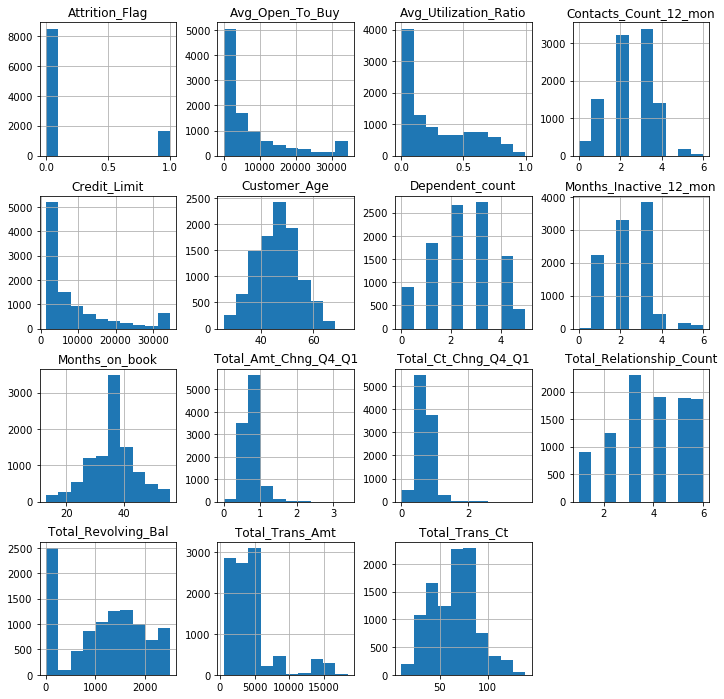

In [8]:
#Examine distributions of numeric features
histlist = bc.hist(figsize = (12,12))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx<br>
Summary of Numeric Feature Distributions<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
  
Avg_Open_To_Buy, Avg_Utilization_Rate, & Credit_limit have similar right-skewed distributions.
  
Customer_Age and Months_on_book are similarly normally distributed.
  
Contacts_Count_12_mon and Months_inactive_12_mon have similar distributions.
  
Total_Amt_Chng_Q4_Q1 and Total_Ct_Chng_Q4_Q1 have similar distributions.

Further Evaluation of numeric features is conducted using Correlation Heat Map.  

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Feature Exploration -  Categorical    
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

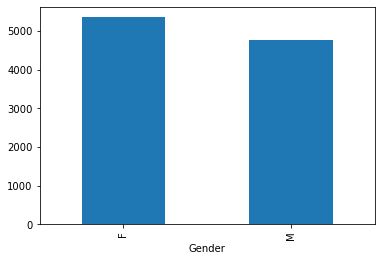

In [9]:
# Distribution of Gender
bc.groupby('Gender').size().plot.bar()
plt.show()

In [10]:
# Explore Gender Relationship with Attrition_Flag
t1 = pd.crosstab(bc['Gender'], bc['Attrition_Flag'])
t1['Total'] = t1.sum(axis=1)
t1.loc['Total'] = t1.sum()
t1['Attrition_Percent'] = ((t1.iloc[:,0])/((t1.iloc[:,0])+(t1.iloc[:,1])))
print(t1)

Attrition_Flag     0     1  Total  Attrition_Percent
Gender                                              
F               4428   930   5358           0.826428
M               4072   697   4769           0.853848
Total           8500  1627  10127           0.839340


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: Women have a higher attrition rate.  
Action: Transform to Binary Variable.  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

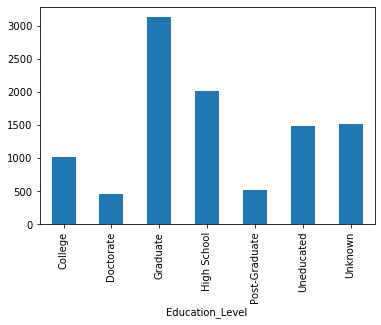

In [11]:
# Distribution of Education Level
bc.groupby('Education_Level').size().plot.bar()
plt.show()

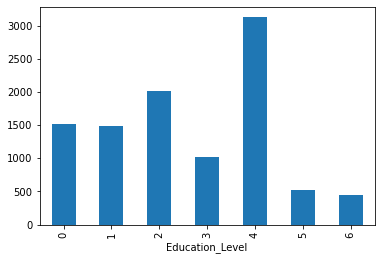

In [12]:
# Maybe we can turn an education into an ordinal variable 
edu_ordinal = {
    "Unknown": 0,
    "Uneducated": 1,
    "High School": 2,
    "College": 3,
    "Graduate": 4,
    "Post-Graduate":5,
    "Doctorate":6
}

def ordinalize(edu):
    return edu_ordinal[edu]
bc.Education_Level = bc.apply(lambda row: ordinalize(row.Education_Level),axis=1)
bc.groupby('Education_Level').size().plot.bar()
plt.show()

In [13]:
# Explore Education_Level Relationship with Attrition_Flag
t2 = pd.crosstab(bc['Education_Level'], bc['Attrition_Flag'])
t2['Total'] = t2.sum(axis=1)
t2.loc['Total'] = t2.sum()
t2['Attrition_Percent'] = ((t2.iloc[:,1])/((t2.iloc[:,0])+(t2.iloc[:,1])))
print(t2)

Attrition_Flag      0     1  Total  Attrition_Percent
Education_Level                                      
0                1263   256   1519           0.168532
1                1250   237   1487           0.159381
2                1707   306   2013           0.152012
3                 859   154   1013           0.152024
4                2641   487   3128           0.155691
5                 424    92    516           0.178295
6                 356    95    451           0.210643
Total            8500  1627  10127           0.160660


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: Clients with Doctorates have the highest attrition rate at ~21%.   
We also note that Clients w/Post_Graduate & Unknown education have higher attrition rates.    
High School Graduates and College educated clients have the lowest attrition rate.  
Uneducated clients have near the average attrition at ~16%.  
  
Action: Dummy encode Education Level  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

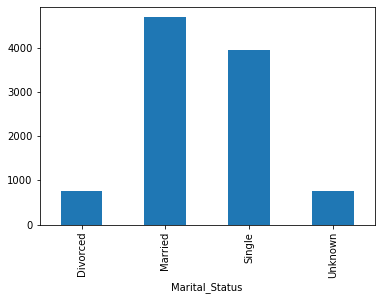

In [14]:
# Explore Marital Status Distribution
bc.groupby('Marital_Status').size().plot.bar()
plt.show()

In [15]:
# Explore Marital_Status Relationship with Attrition_Flag
t3 = pd.crosstab(bc['Marital_Status'], bc['Attrition_Flag'])
t3['Total'] = t3.sum(axis=1)
t3.loc['Total'] = t3.sum()
t3['Attrition_Percent'] = ((t3.iloc[:,0])/((t3.iloc[:,0])+(t3.iloc[:,1])))
print(t3)

Attrition_Flag     0     1  Total  Attrition_Percent
Marital_Status                                      
Divorced         627   121    748           0.838235
Married         3978   709   4687           0.848731
Single          3275   668   3943           0.830586
Unknown          620   129    749           0.827770
Total           8500  1627  10127           0.839340


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: Married Clients have the lowest attrition.  
Unknown, Single, and Divorced have higher than mean attritition rates.  
Action: Create New binary Variable isMarried.  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

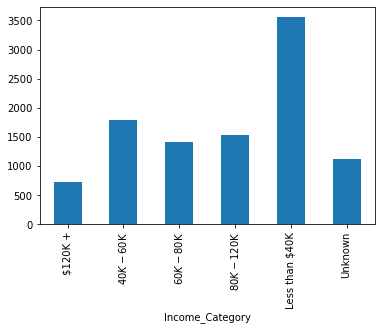

In [16]:
# Explore Income_Category Distribution
bc.groupby('Income_Category').size().plot.bar()
plt.show()

In [17]:
# Explore Income_Category Relationship with Attrition_Flag
t4 = pd.crosstab(bc['Income_Category'], bc['Attrition_Flag'])
t4['Total'] = t4.sum(axis=1)
t4.loc['Total'] = t4.sum()
t4['Attrition_Percent'] = ((t4.iloc[:,0])/((t4.iloc[:,0])+(t4.iloc[:,1])))
print(t4)

Attrition_Flag      0     1  Total  Attrition_Percent
Income_Category                                      
$120K +           601   126    727           0.826685
$40K - $60K      1519   271   1790           0.848603
$60K - $80K      1213   189   1402           0.865193
$80K - $120K     1293   242   1535           0.842345
Less than $40K   2949   612   3561           0.828138
Unknown           925   187   1112           0.831835
Total            8500  1627  10127           0.839340


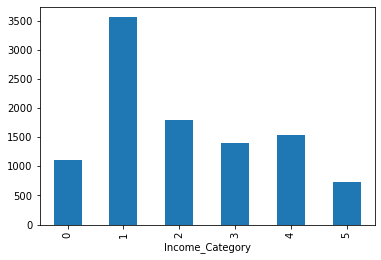

In [18]:
# Maybe we can turn an education into an ordinal variable 
income_ordinal = {
    "Unknown": 0,
    "Less than $40K": 1,
    "$40K - $60K": 2,
    "$60K - $80K": 3,
    "$80K - $120K": 4,
    "$120K +":5
}

def inc_ordinalize(edu):
    return income_ordinal[edu]
bc.Income_Category = bc.apply(lambda row: inc_ordinalize(row.Income_Category),axis=1)
bc.groupby('Income_Category').size().plot.bar()
plt.show()

In [19]:
# Explore Income_Category Relationship with Attrition_Flag
t4 = pd.crosstab(bc['Income_Category'], bc['Attrition_Flag'])
t4['Total'] = t4.sum(axis=1)
t4.loc['Total'] = t4.sum()
t4['Attrition_Percent'] = ((t4.iloc[:,1])/((t4.iloc[:,0])+(t4.iloc[:,1])))
print(t4)

Attrition_Flag      0     1  Total  Attrition_Percent
Income_Category                                      
0                 925   187   1112           0.168165
1                2949   612   3561           0.171862
2                1519   271   1790           0.151397
3                1213   189   1402           0.134807
4                1293   242   1535           0.157655
5                 601   126    727           0.173315
Total            8500  1627  10127           0.160660


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: 120k+ represent the highest attrition rate, followed by Less than 40k.  
60-80K clients have the lowest attrition rate, followed by 40-60k, then 80-120k.  
Unknown income has a higher than mean attrition rate. 
  
Action: Income_Category dummy encoded to retain this information.  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

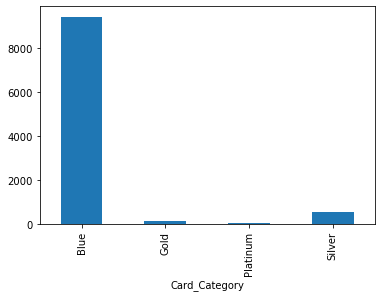

In [20]:
# Explore Card_Category Distribution
bc.groupby('Card_Category').size().plot.bar()
plt.show()

In [21]:
# Explore Card_Category Relationship with Attrition_Flag
t5 = pd.crosstab(bc['Card_Category'], bc['Attrition_Flag'])
t5['Total'] = t5.sum(axis=1)
t5.loc['Total'] = t5.sum()
t5['Attrition_Percent'] = ((t5.iloc[:,0])/((t5.iloc[:,0])+(t5.iloc[:,1])))
print(t5)

Attrition_Flag     0     1  Total  Attrition_Percent
Card_Category                                       
Blue            7917  1519   9436           0.839021
Gold              95    21    116           0.818966
Platinum          15     5     20           0.750000
Silver           473    82    555           0.852252
Total           8500  1627  10127           0.839340


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: While there is a marked difference in the attrition rate based by card  
category, we see that 9436/10127 or 93% of clients are Blue Card holders.  

Action: Drop Card_Category.  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Feature Transformation -  Categorical    
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [22]:
# Tranform Gender and Marital_Status into Binary Features
bc.Gender.replace({'F': 1, 'M': 0}, inplace=True)
bc.Marital_Status.replace({'Married': 1,'Divorced': 0, 'Single': 0, 'Unknown': 0}, inplace=True)

# Rename Transformed Categorical Variables
bc.rename(columns={'Gender': 'isFemale', 'Marital_Status': 'isMarried'}, inplace = True)

#Convert to integers
bc['isFemale'] = bc['isFemale'].astype('int64')
bc['isMarried'] = bc['isMarried'].astype('int64')

bc.head()

,Attrition_Flag,Customer_Age,isFemale,Dependent_count,Education_Level,isMarried,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,45,0,3,2,1,3,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,1,5,4,0,1,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,0,3,4,1,4,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,1,4,2,0,1,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,0,3,1,1,3,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [23]:
# Dummy encode Income_Category and Education_Level
dummy_cols = ['Income_Category', 'Education_Level']
bc_dum= pd.get_dummies(bc, columns=dummy_cols)

# Drop Card_category
bc_trans = bc_dum.drop(columns=['Card_Category'])

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Target Exploration and Transformation    
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

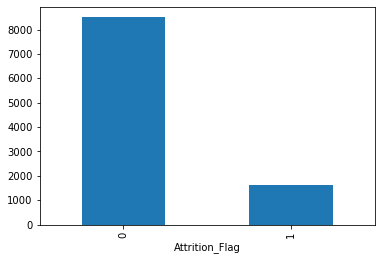

In [24]:
# Examine Attrition Rate
bc_trans.groupby('Attrition_Flag').size().plot.bar()
plt.show()

In [26]:
# Determine extent of churn
churn_count = len(bc_trans[bc_trans['Attrition_Flag']== 1])
no_churn_count = len(bc_trans[bc_trans['Attrition_Flag']==0])
pct_churn_count = churn_count / (churn_count + no_churn_count)
print('Percentage of Attrited Customers is: ', round(pct_churn_count*100,2),'%')
pct_no_churn_count = no_churn_count / (churn_count + no_churn_count)
print('Percentage of Existing Customers is: ', round(pct_no_churn_count*100,2),'%')

Percentage of Attrited Customers is:  16.07 %
Percentage of Existing Customers is:  83.93 %


We note an imbalanced data set with 16.07% churn (attrited customers)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Exploring Feature and Target Correlation to eliminate Multicollinearity   
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

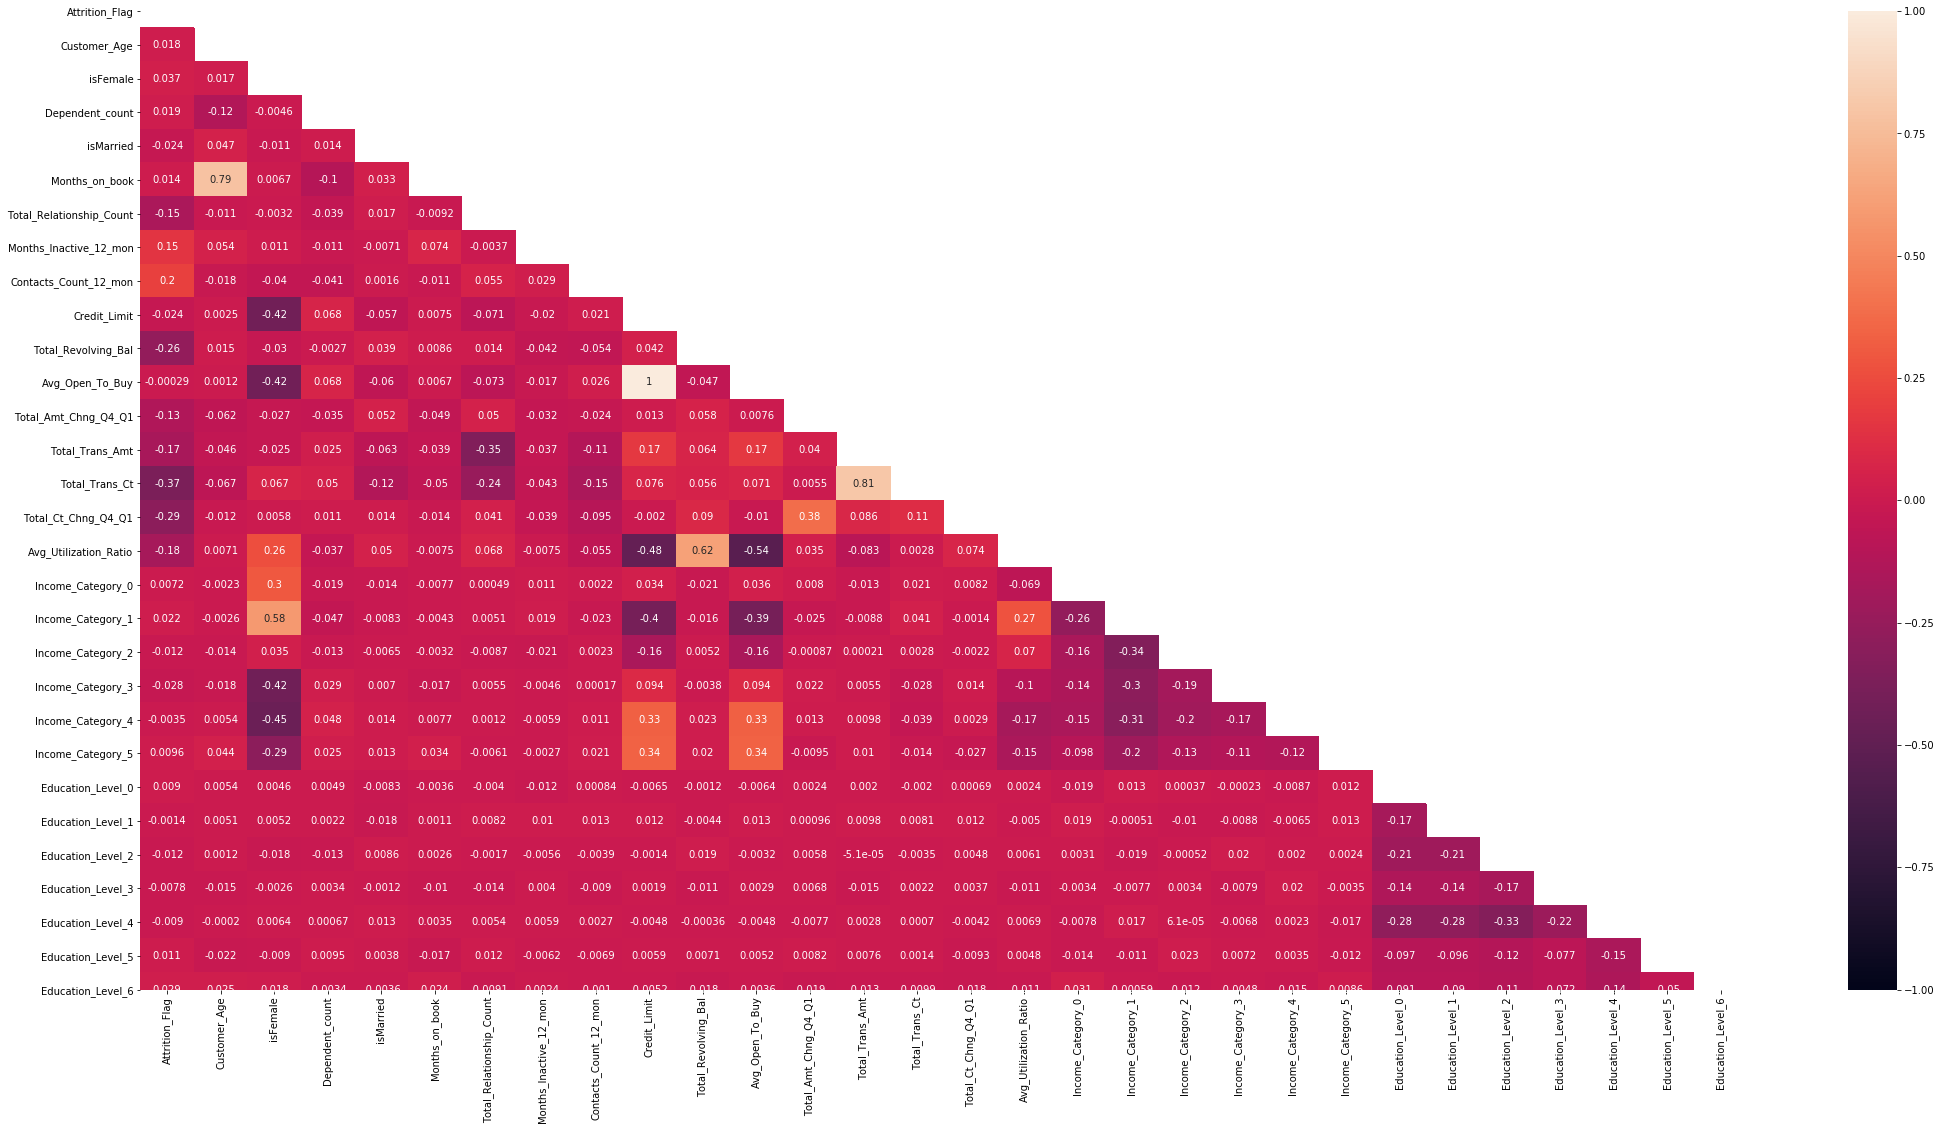

In [27]:
# Correlation Matrix for multicollinearity
plt.figure(figsize=(36, 18))
mask = np.triu(np.ones_like(bc_trans.corr(), dtype=np.bool))
heatmap = sns.heatmap(bc_trans.corr(), mask=mask, vmin=-1, vmax=1, annot=True)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Summary: 

Customer_Age and Months_on_book are highly correlated.    
Action: removing Age to retain banking-relationship    
  
Credit limit is perfectly correlated with Avg_open_to_buy  
Action: Drop Credit Limit  
  
Total_Trans_Cnt and Total_Trans_Amt are highly correlated.  
Action: Create New Feature Average Purchase = Total trans amount / Total Trans Count  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  


In [ ]:
#Create new Average_Purchase feature
bc_trans['Avg_Purchase'] = (bc_trans['Total_Trans_Amt'])/(bc_trans['Total_Trans_Ct'])

# Drop Customer_Age and Credit Limit
bc_clean = bc_trans.drop(columns=['Customer_Age', 'Credit_Limit', 'Total_Trans_Amt', 'Total_Trans_Ct'])

In [ ]:
# Re-examine correlations
# Correlation Matrix for multicollinearity
plt.figure(figsize=(36, 18))
mask = np.triu(np.ones_like(bc_clean.corr(), dtype=np.bool))
heatmap = sns.heatmap(bc_clean.corr(), mask=mask, vmin=-1, vmax=1, annot=True)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Prepare the data for Modeling<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [ ]:
# Min Max Scale the Data set
scaler = MinMaxScaler()
bc_norm = pd.DataFrame(scaler.fit_transform(bc_clean), index=bc_clean.index,
columns=bc_clean.columns)
bc_norm.describe()

In [ ]:
# Paritition the data set
bcTrain, bcTest = train_test_split(bc_norm, test_size = 0.3, random_state=1)

y_train= bcTrain['Attrition_Flag']
X_train= bcTrain.drop(columns=['Attrition_Flag'])

y_test= bcTest['Attrition_Flag']
X_test= bcTest.drop(columns=['Attrition_Flag'])

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Model Strategies:<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Logistic Regression: (Martin insert explanation)<br>
<br>
SVM w/gradient boosting: (Martin insert explanation)<br>
<br>
Random Forest: (Filipp insert explanation)<br>
<br>
Linear Discriminant Analysis: (Filipp insert explanation)<br>
<br>
Quadratic Discriminant Analysis: (Filipp insert explanation)<br>
<br>
Neural Network: (Roberto insert explanation)<br>
<br>
Ensemble - Voting Classifier: (Roberto insert explanation)<br>
<br> 

In [ ]:
# Helper functions
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(y_train, model.predict(X_train))
    print(title + ' - test results')
    y_pred = model.predict(X_test)
    print(title + ' Classification Summary')
    classificationSummary(y_test, y_pred)
    print(title + ' Classification Report')
    print(classification_report(y_test, y_pred))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Neural Network  
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [ ]:
# Train Neural Network with 1 hidden node
clf = MLPClassifier(hidden_layer_sizes=(1), activation='logistic', solver='lbfgs',
                    max_iter = 500, random_state=1)
clf.fit(X_train, y_train.values)
clf_confusion = confusionMatrices(clf, 'Neural network w/1 hidden layer')

In [ ]:
param_grid = {
    'hidden_layer_sizes': list(range(1, 10)),
}
neuralNet = MLPClassifier(activation='logistic', solver='lbfgs', learning_rate = 'adaptive', random_state=1, max_iter=5000)
gridSearch = GridSearchCV(neuralNet, param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

neuralNet = gridSearch.best_estimator_
neuralNet_confusion = confusionMatrices(neuralNet, 'Neural network')

In [ ]:
def modelGainsChart(model, title, ax=None):
    result = pd.DataFrame({
        'actual': y_test,
        'prob': model.predict_proba(X_test)[:, 1]
})

    result = result.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    ax = gainsChart(result.actual, ax=ax)
    ax.set_title(title)
    return ax

ax = modelGainsChart(neuralNet, 'Neural Network')

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Ensemble - Voting Classifier<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

In [ ]:
# create a dictionary of our models
estimators=[('Logistic Regression', ), ('SVM', ), ('randomForest', ), ('Linear Discriminant Analysis',), ('Neural Net', clf), ('Tuned Neural Net'),neuralNet ]
# create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard', weights=[])
# fit model to training data
ensemble.fit(X_train, y_train)
# Confusion Matrix of Ensemble model
ensemble_confusion = confusionMatrices(ensemble, 'Neural network')


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Results and Final Model Selection:<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

(performance measures, etc.)

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  
Discussion and Conclusion:<br>
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx  

(address the problem statement and suggestions that could go beyond the scope of the course.)